In [146]:
# 1.加载所需packages

import json
import time
import jieba
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer


In [144]:
class sim_calculate():
    def __init__(self):
        with open('Newest1.1.txt',encoding='utf8') as f:
            self.content = f.readlines()
        with open('../chinese_stopwords.txt') as f:
            self.stop = [line.strip() for line in f.readlines()]  
        with open('titles_all', encoding='utf8')as f:
            for file in f:
                self.titles_all = [file.strip() for file in f]
        
        self.titles_before_segment = self.get_full_contents(self.content)
        self.titles_after_segment = self.text_to_segment(self.titles_all)
        self.loaded_vec, self.tfidftransformer, self.tfidf_array = self.load_model()
        
   
    #  将原文本转化为 ['title1','title2','...'] 格式
    def get_full_contents(self, content):
        
        titles_before_segment = []
        for new in content:
            #获得字典中每个问答对的标题
            content  = json.loads(new)['Title'] 
            titles_before_segment.append(content)
        return titles_before_segment
        return self.titles_all
    
    # 5. 将原视文本分词，去停用词，转化为 ['word1 word2 word3','...'] 格式
    def text_to_segment(self, content):
        # 对标题分词，返回列表
        titles = []
        for new in content:
            #获得字典中每个问答对的标题
#             title = json.loads(new)['Title'] 
            title = new
            #将标题分词，提出不在停用词中的词，组成列表
            title_cut = [w for w in jieba.cut(title) if w not in self.stop]

            #将标题中的词组成字符串存入标题列表中
            cut_sentence = ' '.join(title_cut)
            titles.append(cut_sentence)
        return titles
    
    # 训练与保存模型
    def models_train_save(self):
        vector = CountVectorizer()
        res = vector.fit_transform(self.titles_after_segment)
        transfomer = TfidfTransformer()
        tfidf = transfomer.fit_transform(res)
        
        feature_path = 'models/feature.pkl'
        with open(feature_path, 'wb') as f:
            pickle.dump(vector.vocabulary_, f)

        tfidftransfomer_path = 'models/tfidftransformer.pkl'
        with open(tfidftransfomer_path, 'wb') as f:
            pickle.dump(transfomer, f)

        array_path = 'models/array.pkl'
        with open(array_path,'wb')as f:
            pickle.dump(tfidf.toarray(), f)
    
    # 加载模型        
    def load_model(self):
        # 加载特征
        feature_path = 'models/feature.pkl'
        loaded_vec = CountVectorizer(decode_error="replace", vocabulary=pickle.load(open(feature_path, "rb")))
        # 加载TfidfTransformer
        tfidftransformer_path = 'models/tfidftransformer.pkl'
        tfidftransformer = pickle.load(open(tfidftransformer_path, "rb"))
        array_path = 'models/array.pkl'
        tfidf_array = pickle.load(open(array_path, 'rb'))
        return loaded_vec, tfidftransformer, tfidf_array
    
    # 计算余弦相似度
    def sim(self,array1,array2):
        num = float(np.matmul(array1,array2))
        s = np.linalg.norm(array1)*np.linalg.norm(array2)
        return num/s
    
    #  加载单句测试文本，计算测试文本tfidf,返回向量矩阵
    def get_test_tfidf_array(self):
        title_cut = [w for w in jieba.cut(self.test) if w not in self.stop]

        #将标题中的词组成字符串存入标题列表中
        cut_sentence = ' '.join(title_cut)
        test_tfidf = self.tfidftransformer.transform(self.loaded_vec.transform([cut_sentence]))
        test_tfidf_array = test_tfidf.toarray()
        return test_tfidf_array
    
        
    # 获取降维后向量矩阵
    def get_dicomposition_array(self, array):
        pca = PCA(n_components=10)
        pca.fit(array)
        decomposition_array = pca.transform(array)
        return decomposition_array
    
    # 计算余弦相似度
    def single_test_to_sim_calcu(self,array1,array2):
        
        results = {}
        for i in range(len(self.tfidf_array)):  
                score = self.sim(array1[i], array2[0])
                if score > 0.2:
                    score = round(score,2)

                    results[score] = i
        results = sorted(results.items(), key=lambda item:item[0], reverse=True)
        for score, index in results:
            print("第"+str(index+1)+"篇文章:"+self.titles_before_segment[index]+'\n'+" 相似度:"+str(score))

    
    def main(self,test):
        start = time.time()
        self.test = test
        self.test_tfidf_array = self.get_test_tfidf_array()
        
        #获得降维后的数据集向量
        self.corpus_decom_array = self.get_dicomposition_array(self.tfidf_array)
        print("Toal Cost:{}s".format(round(time.time()-start, 2)))
        self.corpus_test_total = np.r_[self.tfidf_array,self.test_tfidf_array]       
        self.corpus_test_decom_array = self.get_dicomposition_array(self.corpus_test_total)
        print("Toal Cost:{}s".format(round(time.time()-start, 2)))
        
        #获得降维后的测试数据向量
        self.test_decom_array = [self.corpus_test_decom_array[-1]]
        
        self.single_test_to_sim_calcu(self.tfidf_array, self.test_tfidf_array)
        print('-------------------------------')
        self.single_test_to_sim_calcu(self.corpus_decom_array, self.test_decom_array)
        print(round(time.time()-start, 2))
sim_calculator = sim_calculate()        

In [145]:
test = "如果人生是痛苦的，那为什么还要继续活着？"
sim_calculator.main(test)

Toal Cost:1.54s
Toal Cost:3.09s
第3753篇文章:如果人生是痛苦的，那为什么还要继续活着？
 相似度:1.0
第966篇文章:和他人相处时感到尴尬，还要继续吗？
 相似度:0.42
第2999篇文章:现在活着只是为了父母，活着有什么意义？
 相似度:0.41
第3002篇文章:感觉我已经看透了自己的人生，活着的意义到底什么？
 相似度:0.37
第3005篇文章:活着的意义是什么？
 相似度:0.36
第2258篇文章:大学情侣间只知道吃喝玩乐还要继续吗？
 相似度:0.34
第3469篇文章:重新开始新的咨询很麻烦，还要不要继续做心理咨询？
 相似度:0.33
第144篇文章:缺爱的人，该怎么走自己的人生？
 相似度:0.3
第2581篇文章:因婚房的事闹过，后来男朋友失踪，我还要继续坚持吗？
 相似度:0.28
第4692篇文章:暧昧了三个多月，对方不提见面，还要继续吗？
 相似度:0.27
第3097篇文章:自己做了很多事，可以还要被批评，我该怎么办？
 相似度:0.25
第3501篇文章:16岁，吃了抑郁药感觉不到自己活着，想自杀怎么办？
 相似度:0.24
第3752篇文章:人为什么活着？为父母而生，为父母而死？
 相似度:0.23
第2277篇文章:为什么男生有女朋友之后，还要存其他女生的照片？
 相似度:0.22
第2615篇文章:les分手，在一起三年半，走不出来害怕活着怎么办？
 相似度:0.21
第4257篇文章:学历挺好，但心理有障碍，这样的人生还有意义吗？
 相似度:0.2
-------------------------------


E:\Learing\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


第3753篇文章:如果人生是痛苦的，那为什么还要继续活着？
 相似度:1.0
第2999篇文章:现在活着只是为了父母，活着有什么意义？
 相似度:0.98
第3839篇文章:以前得过神经症，怕以后碍于面子不去咨询耽误病程？
 相似度:0.97
第4560篇文章:我家条件一般，但父母爱麻将，该怎么办？
 相似度:0.96
第4348篇文章:怎样去面对生命的虚无感？在死亡面前生命有什么意义？
 相似度:0.95
第4570篇文章:婚姻中出轨，已经断了，以后生活如何原谅自己？
 相似度:0.94
第4331篇文章:本人极度恐婚、厌男，也许不结婚才是我最好的选择吧？
 相似度:0.93
第4545篇文章:第一次出面买心仪的二手房，语言表达能力差，怎么办？
 相似度:0.92
第4642篇文章:父母之间冷战，隔阂很大，看着好难受，怎么应对？
 相似度:0.91
第4672篇文章:提离婚老公要报复我，该怎么做才能打消他报复的念头？
 相似度:0.9
第4585篇文章:关于团团伙伙（或者圈子），到底是什么造成的？
 相似度:0.89
第4654篇文章:这两点所说的“幻像，不是一回事吧？
 相似度:0.88
第4651篇文章:有人没事找事，且总光明正大针对我，还贬低我怎么办？
 相似度:0.87
第4686篇文章:看莎翁情史，感叹，世界还会有纯洁美好的爱情吗？
 相似度:0.86
第4692篇文章:暧昧了三个多月，对方不提见面，还要继续吗？
 相似度:0.85
第4626篇文章:总想证明自己，尤想通过异性认可来证明自己，何解？
 相似度:0.84
第4637篇文章:高中，返校前我连作业都写不完，自责，如何停止内耗？
 相似度:0.83
第4662篇文章:14周岁少年，缺少自主控制力，性格有两种极端？
 相似度:0.82
第4552篇文章:怎样判断青春期女同性恋？作为家长该怎么引导孩子？
 相似度:0.81
第4675篇文章:睡不着，脑子回想坏事，并对黑暗恐惧，需要疏导吗？
 相似度:0.8
第4674篇文章:高一，父母欺骗了我，将我骗入烂高中，我该怎么办？
 相似度:0.79
第4510篇文章:32岁已婚女性，买房买贵了，晚上焦虑出汗失眠？
 相似度:0.78
第4639篇文章:工作强度本来就大，刚怀孕遇到升职机会，要放弃吗？
 相似度:0.77
第4666篇文章:双向情感障碍，因

In [26]:
#  12. 加载测试数据集，计算tfidf，计算余弦相似度
with open('Newest1.2.txt', encoding='utf8') as f:
    test_content = f.readlines()
test_titles_after_segment = text_to_segment(test_content)

def doc_to_tfidf2(seg_doc):
    test_tfidf = tfidftransformer.transform(loaded_vec.transform([seg_doc]))
    return test_tfidf

def test_sim_calculate(test_titles):
    
    test_titles_before_segment = get_full_contents(test_content)
    for index, new in enumerate(test_titles_after_segment[0:5]):
        results = {}
        print(test_titles_before_segment[index])
        new_tfidf = doc_to_tfidf2(new)
        for i in range(len(tfidf_array)):  
            score = sim(tfidf_array[i], new_tfidf.toarray()[0])
            if score > 0.2:
                score = round(score,2)                
                results[score] = i
        results = sorted(results.items(), key=lambda item:item[0], reverse=True)
        for score, index in results:
            print("第"+str(index)+"篇文章:"+titles_before_segment[index]+'\n'+" 相似度:"+str(score))
            
test_sim_calculate(test_titles_after_segment)

老是觉得自己做错了，但又控制不住自己怎么办？
第23篇文章:我讨厌这样的自己，但控制不住自己发疯，怎么办？
 相似度:0.5
第858篇文章:自己也知道，但是控制不住咬指甲，是什么问题？
 相似度:0.47
第627篇文章:30岁，我觉得老是自己一个人，不会跟人沟通怎么办
 相似度:0.38
第71篇文章:孩子控制不住掏耳朵，是学习压力大导致的强迫症吗？
 相似度:0.36
第349篇文章:高二，爸爸去世，最近一年，情绪越来越控制不住？
 相似度:0.35
第527篇文章:34岁男性，家父感情细腻，我控制不住伤害他？
 相似度:0.33
第400篇文章:6岁女儿老是担心爸爸妈妈吵架，总觉得有不好的事情？
 相似度:0.31
第846篇文章:分手后，老是不开心，半夜睡不着想哭？
 相似度:0.26
第714篇文章:好像活在他们眼里，或被人控制，我觉得我好像死了？
 相似度:0.25
第486篇文章:大学生，找漂亮女朋友怕驾驭不住是什么心理？
 相似度:0.21
第817篇文章:父母感情不好，爸爸老是向我倾诉，害怕家里来电话？
 相似度:0.2
正处于心境稳定期的情绪病患者，可以寻求怎样的帮助？
第540篇文章:无法处理持续低落的情绪，咨询对现状有何帮助？
 相似度:0.3
第175篇文章:单纯心理咨询能治好心境恶劣吗？要不要去医院？
 相似度:0.27
第91篇文章:考研失败重找工作，焦虑迷茫后悔，现实还是心境问题？
 相似度:0.26
第284篇文章:情绪外露，什么方法可以让自己情绪不被轻易发现？
 相似度:0.24
第469篇文章:自卑的人，应该看什么专业书籍，对自我修通有帮助？
 相似度:0.23
第820篇文章:我对母亲情绪变化很敏感，如何停止接收她的负面情绪？
 相似度:0.21
男友承认了他花心，希望我帮他改，该怎么改？
第187篇文章:我感觉我老公聚会时 眼神总停在女性脸上 他是花心吗
 相似度:0.23
第907篇文章:工资学历都跟男友差不多，男友父母要我签婚前协议？
 相似度:0.22
如何在成年后应对客体恒常性的缺失?
第186篇文章:如果别人改变我，想让我低三下四我该怎么应对？
 相似度:0.34
第503篇文章:20岁女，感受不到相应情绪，情感缺失该怎么判断呢？
 相似度:0.32
第63篇文章:和女友刚在一起八个月，去她父母店里帮忙，如何应对

E:\Learing\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
E:\Learing\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


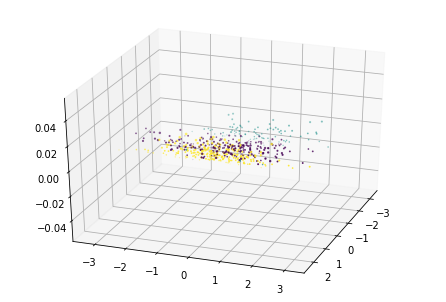

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.datasets.samples_generator import make_classification
X, y = make_classification(n_samples=1000, n_features=3, n_redundant=0, n_classes=3, n_informative=2,
                           n_clusters_per_class=1,class_sep =0.5, random_state =10)
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
plt.scatter(X[:, 0], X[:, 1], X[:, 2],marker='o',c=y)

In [7]:
from pandas.plotting import parallel_coordinates, radviz, andrews_curves
import seaborn as sns

[0.43377069 0.3716351 ]
[1.21083449 1.0373882 ]


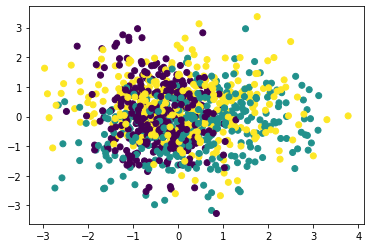

In [83]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
X_new = pca.transform(X)
plt.scatter(X_new[:, 0], X_new[:, 1],marker='o',c=y)
plt.show()

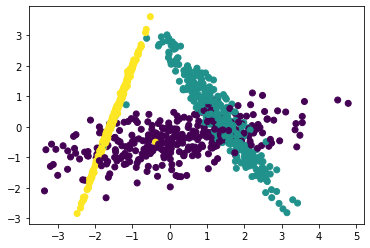

In [84]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X,y)
X_new = lda.transform(X)
plt.scatter(X_new[:, 0], X_new[:, 1],marker='o',c=y)
plt.show()

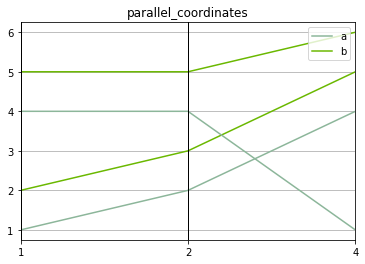

In [138]:
# 多维度数据平行坐标可视化
dict1 = {'1':[1,2,4,5],'2':[2,3,4,5],'4':[4,5,1,6],'3':['a','b','a','b']}
dict_df = pd.DataFrame(dict1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates, radviz, andrews_curves
import seaborn as sns
# data = pd.read_csv('D:\\iris.csv')

plt.figure('多维度-parallel_coordinates')
plt.title('parallel_coordinates')
parallel_coordinates(dict_df, '3', )
plt.show()


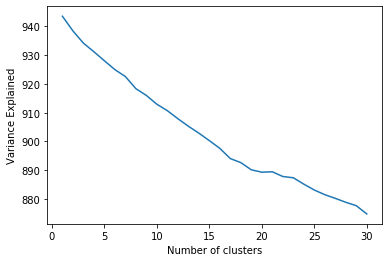

In [6]:
# kmeans 聚类
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist
X=np.array(sim_calculator.tfidf_array)

wx = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(X)
    wx.append(kmeans.inertia_)
plt.plot(range(1, 31), wx)
plt.xlabel('Number of clusters')
plt.ylabel('Variance Explained')
plt.show()

model_kmeans = KMeans(20,random_state=0)
model_kmeans.fit(X)
y_pre = model_kmeans.predict(X)

n_samples, n_features = X.shape
inertias = model_kmeans.inertia_
adjusted_rand_s = metrics.adjusted_rand_score(y_pre, y_pre)